In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import skimage.io as io
import skimage.filters as flt
from skimage.metrics import structural_similarity as SSIM
%matplotlib inline
# since we can't use imports
import numpy as np
import scipy.ndimage.filters as flt
import warnings
import cv2
from glob import glob 

import pylab as pl
from time import sleep
import tensorflow as tf
from tqdm import tqdm
from collections import Counter
from matplotlib import cm
from matplotlib.colors import ListedColormap
import matplotlib as mpl


import sys
sys.path.append('../../scripts')
import open_frame
from pm_algorithm import anisodiff
from data_augmentation import get_generators
from architectures import get_model


CROP = 256
image_size = (CROP,CROP)
typ = "gaussian"
open_frame = getattr(open_frame,typ)


import logging
tf.get_logger().setLevel(logging.ERROR)

import umap
from sklearn.decomposition import PCA

## Data augmentation

In [2]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=1,var1_u=7,CROP1=CROP,BATCH_SIZE=50)

2023-01-29 13:18:53.136988: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/joel/anaconda3/lib/python3.9/site-packages/cv2/../../lib64:
2023-01-29 13:18:53.137008: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-29 13:18:53.137025: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (joel-Latitude-5410): /proc/driver/nvidia/version does not exist
2023-01-29 13:18:53.191698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
xs, ys = next(gen_batch_val.as_numpy_iterator())

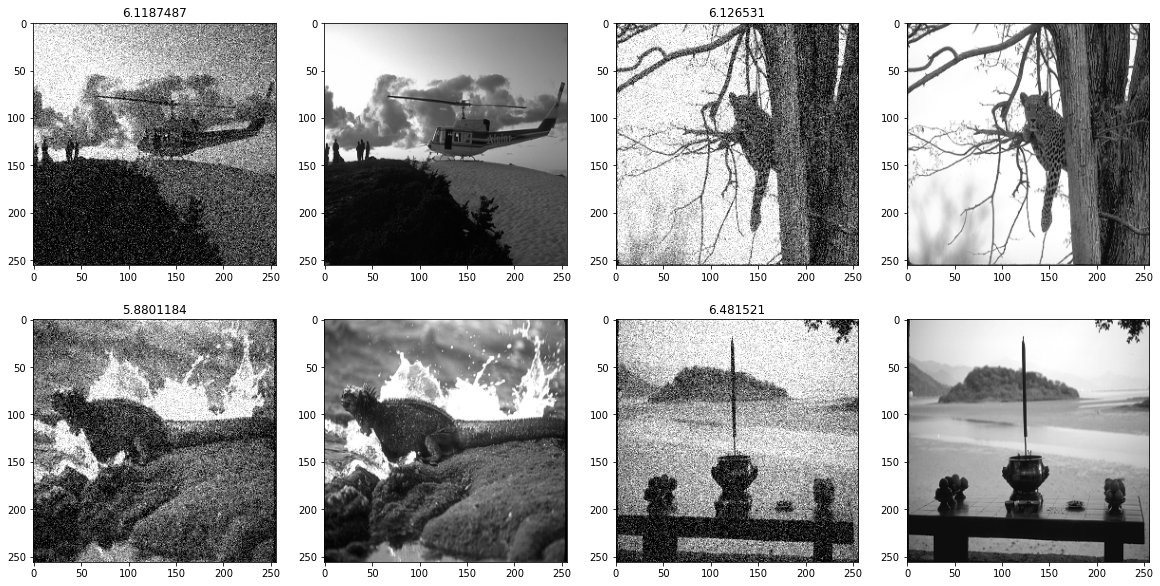

In [4]:
nrows,ncols = 2,4
fig,axs = plt.subplots(nrows=nrows,ncols=ncols,figsize=(20,10))

for i in range(nrows):
    for j in range(ncols//2):
        _ = np.random.choice(len(xs['input']))
        axs[i,2*j].imshow(np.squeeze(xs['input'][_]),cmap='gray')
        axs[i,2*j+1].imshow(np.squeeze(ys[_]),cmap='gray')
        axs[i,2*j].set_title(str(np.mean(xs['input_emb'][_])))
        
plt.show()

# Neural networks

In [8]:
strategy = tf.distribute.MirroredStrategy()
#strategy = tf.distribute.OneDeviceStrategy('/device:GPU:0')

## Training

In [5]:
def loss(y_true,y_pred):
    return 1/(tf.image.psnr(y_true,y_pred,1)) + 1/(tf.math.tan(np.pi*tf.image.ssim(y_true,y_pred,1)/2))

In [ ]:
gen_batch_train,gen_batch_val = get_generators(typ,var1_d=1,var1_u=7,CROP1=CROP,BATCH_SIZE=50)

order = 1
for num_classes in [5,10,15,20,50]:
    print('num_classes: ',num_classes)
    model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = num_classes)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
            loss=loss,)
    #model.load_weights(f"./checkpoints/dec_{typ}_{num_classes}")
    
    callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath= f"./checkpoints/dectaylor_{typ}_{num_classes}",
    save_weights_only=True,
    verbose = True,
    save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, verbose=1)
    ]
    
    history = model.fit(
        gen_batch_train,
        epochs=50,
        steps_per_epoch=10,
        validation_data=gen_batch_val,
        validation_steps=5,
        shuffle=False,
        use_multiprocessing=True,
        callbacks=callbacks,
        workers=1
    )
    
    np.save(f'./history/dectaylor_{typ}_{num_classes}.npy',np.array([history.history['loss'],history.history['val_loss']]))
    

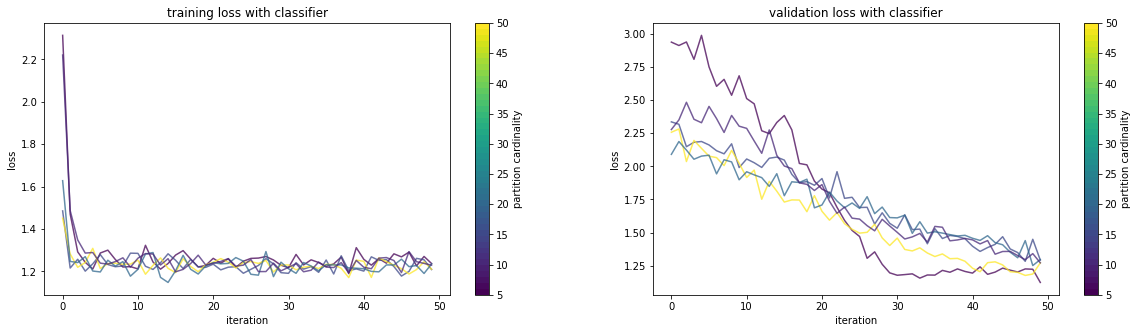

In [2]:
trained = glob(f'./history/dectaylor_*')
w = [int(i.split('_')[-1].split('.')[0]) for i in trained]
n = len(trained)+1
viridis = cm.get_cmap('viridis', 256)
colors = viridis(np.linspace(0, 1, np.amax(w)-np.amin(w)+1))
newcmp = ListedColormap(colors)
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols=2,figsize=(20,5))

for j,i in enumerate(trained):
    
    v = np.load(i)
    axs[0].plot(v[0],alpha=0.75,color = colors[w[j]-np.amin(w)])
    axs[1].plot(v[1],alpha=0.75,color = colors[w[j]-np.amin(w)])
    
axs[0].set_title("training loss with classifier")
axs[1].set_title("validation loss with classifier")

axs[0].set_xlabel('iteration')
axs[0].set_ylabel('loss')

axs[1].set_xlabel('iteration')
axs[1].set_ylabel('loss')
    
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[0],label='partition cardinality')
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[1],label='partition cardinality')
    
plt.show()



# Results

# Results with first function

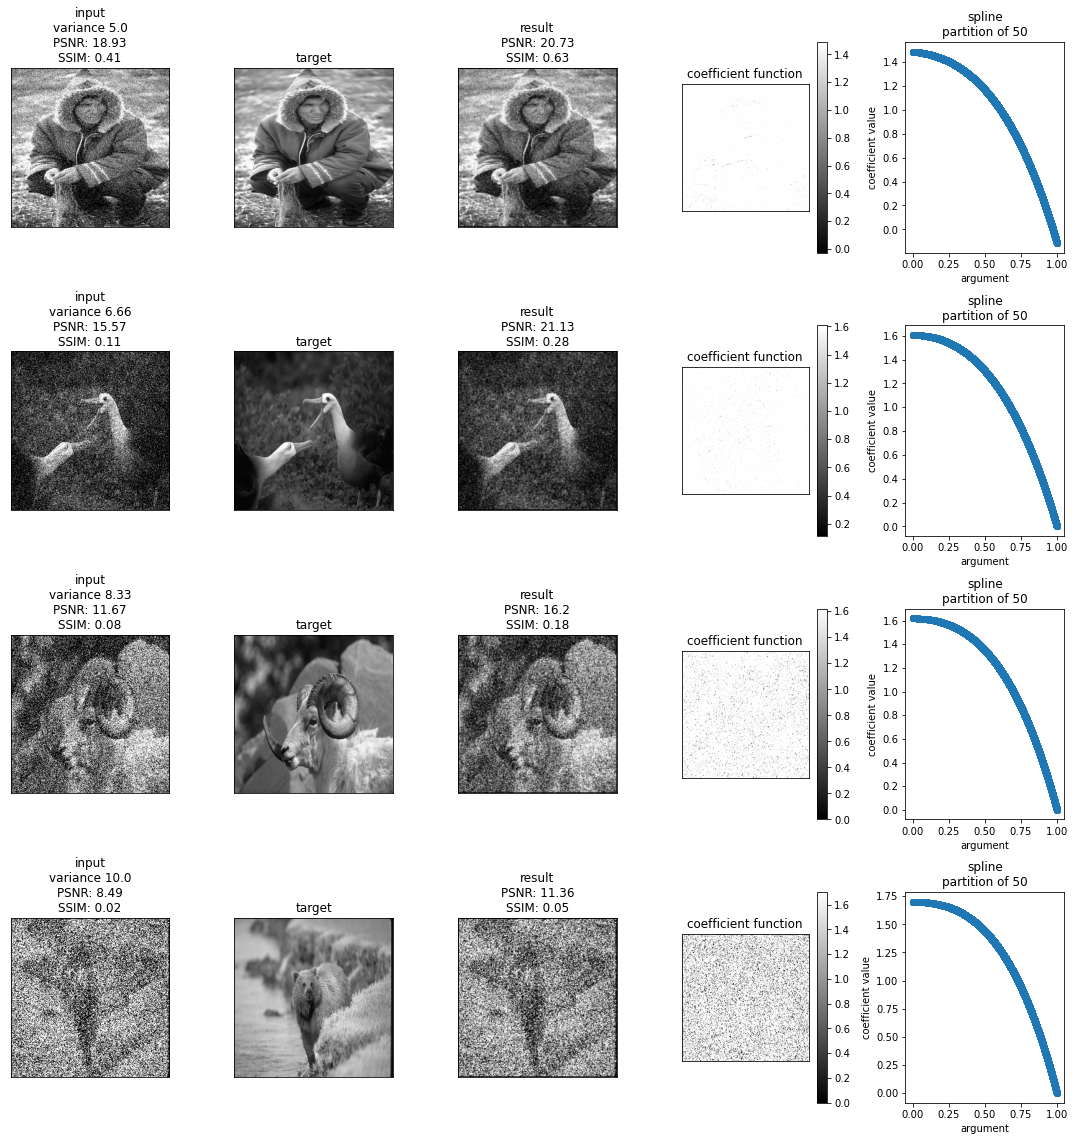

In [40]:
num_classes = 50
model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")

w = np.linspace(5,10,4)
fig,axs = plt.subplots(ncols = 5,nrows = int(np.ceil(len(w))),figsize=(15,4*len(w)))
for i,m in enumerate(w):

    
    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=5)
    ims = next(gen_batch_val.as_numpy_iterator())
    p = model(ims[0])
    _ = np.random.choice(len(p))


    psnr_0 = tf.image.psnr(ims[0]['input'][_],ims[1][_],1).numpy()
    ssim_0 = tf.image.ssim(ims[0]['input'][_],ims[1][_],1).numpy()
    clean = p[_]
    psnr = tf.image.psnr(ims[1][_],clean,1).numpy()
    ssim = tf.image.ssim(ims[1][_],clean,1).numpy()
    clean = np.squeeze(clean)
    inputs = tf.keras.Input(shape=image_size + (1,))
    get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
    get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
    get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)
    
    cte = np.squeeze(get_cte(ims[0])[_])
    linear = np.squeeze(get_linear(ims[0])[_])
    quad = np.squeeze(get_quad(ims[0])[_])
    
    visualization = tf.keras.models.Model(model.input,model.get_layer('coeff_x_0').output)
    vis = np.squeeze(visualization(ims[0])[_])


    psnr_0,ssim_0 = int(100*psnr_0)/100,int(100*ssim_0)/100
    psnr,ssim = int(100*psnr)/100,int(100*ssim)/100
    
    
    axs[i,0].imshow(ims[0]['input'][_],cmap='gray')
    axs[i,0].set_title(f'input\nvariance {int(100*m)/100}\nPSNR: {psnr_0}\nSSIM: {ssim_0}')
    axs[i,0].set_xticks([])
    axs[i,0].set_xticklabels([])
    axs[i,0].set_yticks([])
    axs[i,0].set_yticklabels([])
    axs[i,1].imshow(ims[1][_],cmap='gray')
    axs[i,1].set_title('target')
    axs[i,1].set_xticks([])
    axs[i,1].set_xticklabels([])
    axs[i,1].set_yticks([])
    axs[i,1].set_yticklabels([])
    axs[i,2].imshow(clean,cmap='gray')
    axs[i,2].set_title(f'result\nPSNR: {psnr}\nSSIM: {ssim}')
    axs[i,2].set_xticks([])
    axs[i,2].set_xticklabels([])
    axs[i,2].set_yticks([])
    axs[i,2].set_yticklabels([])
    im = axs[i,3].imshow(vis,cmap='gray')
    axs[i,3].set_title('coefficient function')
    plt.colorbar(im,ax=axs[i,3])
    axs[i,3].set_xticks([])
    axs[i,3].set_xticklabels([])
    axs[i,3].set_yticks([])
    axs[i,3].set_yticklabels([])
    
    
    x = np.linspace(0,1,10000)
    x1 = np.power(np.expand_dims(x,axis=-1),np.expand_dims(np.arange(2,num_classes,1),axis=0))
    quad_val = np.sum(np.multiply(np.array([quad]),x1),axis=-1)
    linear_val = linear*x
    
    s = cte -linear_val + quad_val
    
    
    axs[i,4].scatter(x,s)
    axs[i,4].set_xlabel("argument")
    axs[i,4].set_ylabel("coefficient value")
    axs[i,4].set_title(f"spline\npartition of {num_classes}")
    
plt.tight_layout()
plt.show()

# Comparing against Perona Malik

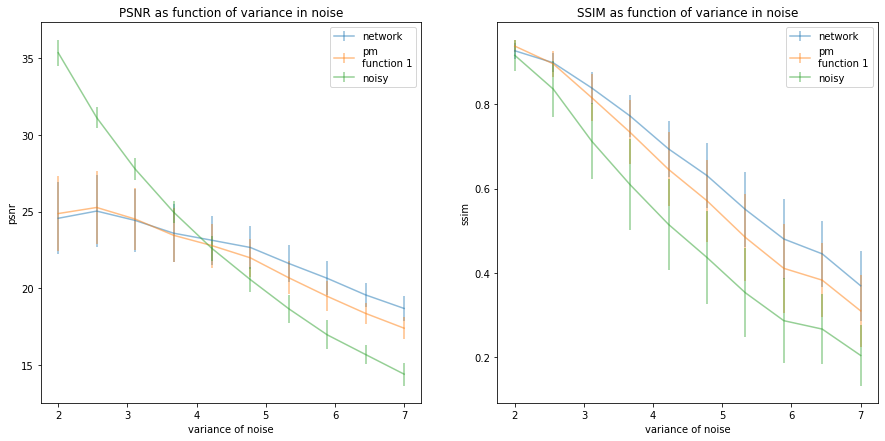

In [41]:
num_classes = 50
model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")

w = np.linspace(2,7,10)
psnr_nn_1,psnr_nn_s_1 = [],[]
ssim_nn_1,ssim_nn_s_1 = [],[]

psnr_pm_1,psnr_pm_s_1 = [],[]
ssim_pm_1,ssim_pm_s_1 = [],[]

psnr_or_1,psnr_or_s_1 = [],[]
ssim_or_1,ssim_or_s_1 = [],[]


for i,m in enumerate(w):
    gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=10)
    
    psnr_nn_1.append([])
    psnr_nn_s_1.append([])
    ssim_nn_1.append([])
    ssim_nn_s_1.append([])
    psnr_pm_1.append([])
    psnr_pm_s_1.append([])
    ssim_pm_1.append([])
    ssim_pm_s_1.append([])
    psnr_or_1.append([])
    psnr_or_s_1.append([])
    ssim_or_1.append([])
    ssim_or_s_1.append([])
    
    for it in range(10):
        ims = next(gen_batch_val.as_numpy_iterator())

        res = model(ims[0])
        psnr = tf.image.psnr(res,ims[1],1).numpy()
        ssim = tf.image.ssim(res,ims[1],1).numpy()
        psnr_nn_1[-1].append(np.copy(psnr))
        psnr_nn_s_1[-1].append(np.copy(psnr))
        ssim_nn_1[-1].append(np.copy(ssim))
        ssim_nn_s_1[-1].append(np.copy(ssim))

        pm = np.array([anisodiff(im,niter = 1) for im in ims[0]['input']])
        pm = np.asarray(pm,dtype='float32')
        psnr = [tf.image.psnr(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
        ssim = [tf.image.ssim(pm[j],ims[1][j],1).numpy() for j in range(len(res))]
        psnr_pm_1[-1].append(np.copy(psnr))
        psnr_pm_s_1[-1].append(np.copy(psnr))
        ssim_pm_1[-1].append(np.copy(ssim))
        ssim_pm_s_1[-1].append(np.copy(ssim))

        psnr = tf.image.psnr(ims[0]['input'],ims[1],1).numpy()
        ssim = tf.image.ssim(ims[0]['input'],ims[1],1).numpy()
        psnr_or_1[-1].append(np.copy(psnr))
        psnr_or_s_1[-1].append(np.copy(psnr))
        ssim_or_1[-1].append(np.copy(ssim))
        ssim_or_s_1[-1].append(np.copy(ssim))
        
    psnr_nn_1[-1] = np.concatenate(psnr_nn_1[-1])
    psnr_nn_s_1[-1] = np.concatenate(psnr_nn_s_1[-1])
    ssim_nn_1[-1] = np.concatenate(ssim_nn_1[-1])
    ssim_nn_s_1[-1] = np.concatenate(ssim_nn_s_1[-1])
    
    psnr_pm_1[-1] = np.concatenate(psnr_pm_1[-1])
    psnr_pm_s_1[-1] = np.concatenate(psnr_pm_s_1[-1])
    ssim_pm_1[-1] = np.concatenate(ssim_pm_1[-1])
    ssim_pm_s_1[-1] = np.concatenate(ssim_pm_s_1[-1])
    
    psnr_or_1[-1] = np.concatenate(psnr_or_1[-1])
    psnr_or_s_1[-1] = np.concatenate(psnr_or_s_1[-1])
    ssim_or_1[-1] = np.concatenate(ssim_or_1[-1])
    ssim_or_s_1[-1] = np.concatenate(ssim_or_s_1[-1])
    
    


psnr_nn_1 = np.mean(psnr_nn_1,axis=-1)
psnr_nn_s_1 = np.std(psnr_nn_s_1,axis=-1)
ssim_nn_1 = np.mean(ssim_nn_1,axis=-1)
ssim_nn_s_1 = np.std(ssim_nn_s_1,axis=-1)
psnr_pm_1 = np.mean(psnr_pm_1,axis=-1)
psnr_pm_s_1 = np.std(psnr_pm_s_1,axis=-1)
ssim_pm_1 = np.mean(ssim_pm_1,axis=-1)
ssim_pm_s_1 = np.std(ssim_pm_s_1,axis=-1)
psnr_or_1 = np.mean(psnr_or_1,axis=-1)
psnr_or_s_1 = np.std(psnr_or_s_1,axis=-1)
ssim_or_1 = np.mean(ssim_or_1,axis=-1)
ssim_or_s_1 = np.std(ssim_or_s_1,axis=-1)

plt.figure(figsize=(15,7))
plt.subplot(121)
plt.errorbar(w,psnr_nn_1,psnr_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,psnr_pm_1,psnr_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,psnr_or_1,psnr_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('psnr')
plt.title('PSNR as function of variance in noise')
plt.legend()

plt.subplot(122)
plt.errorbar(w,ssim_nn_1,ssim_nn_s_1,label='network',alpha=0.5)
plt.errorbar(w,ssim_pm_1,ssim_pm_s_1,label='pm\nfunction 1',alpha=0.5)
plt.errorbar(w,ssim_or_1,ssim_or_s_1,label='noisy',alpha=0.5)


plt.xlabel('variance of noise')
plt.ylabel('ssim')
plt.title('SSIM as function of variance in noise')
plt.legend()
plt.show()

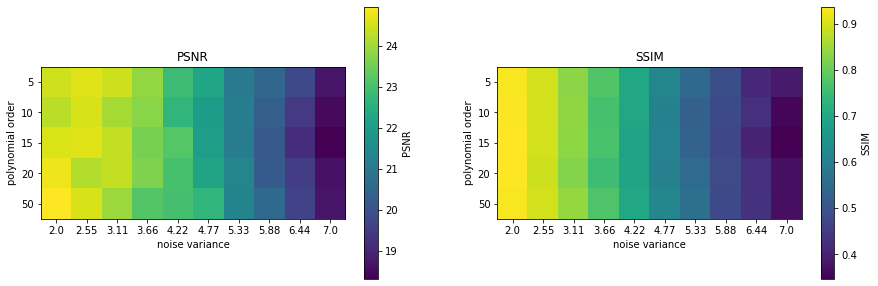

In [74]:
w = np.linspace(2,7,10)
w = np.asarray(100*w,dtype='int')/100
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/dectaylor_{typ}_*.index")])


hist_psnr,hist_ssim = [],[]

for num_classes in ncl:

    psnr_nn_1,ssim_nn_1 = [],[]
    model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = num_classes)
    for i,m in enumerate(w):
        
        model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
        gen_batch_train,gen_batch_val = get_generators(typ,0,w[i],CROP1=CROP,BATCH_SIZE=10)
        
        psnr_nn_1.append([])
        ssim_nn_1.append([])
        for it in range(10):
            ims = np.array(next(gen_batch_val.as_numpy_iterator()))

            res = model(ims[0])
            res = res/np.expand_dims(np.expand_dims(np.amax(res,axis=(1,2)),axis=-2),axis=-2)
            psnr = [tf.image.psnr(res[j],ims[1][j],1).numpy() for j in range(len(res))]
            ssim = [tf.image.ssim(res[j],ims[1][j],1).numpy() for j in range(len(res))]
            psnr_nn_1[-1].append(psnr)
            ssim_nn_1[-1].append(ssim)
            
        psnr_nn_1[-1] = np.mean(psnr_nn_1[-1])
        ssim_nn_1[-1] = np.mean(ssim_nn_1[-1])


    hist_psnr.append(np.copy(psnr_nn_1))
    hist_ssim.append(np.copy(ssim_nn_1))
    


plt.figure(figsize=(15,5))
plt.subplot(121)
plt.imshow(hist_psnr)
plt.xlabel('noise variance')
plt.ylabel('polynomial order')
plt.title('PSNR')
plt.colorbar(label='PSNR')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.subplot(122)
plt.imshow(hist_ssim)
plt.xlabel('noise variance')
plt.ylabel('polynomial order')
plt.title('SSIM')
plt.colorbar(label='SSIM')
plt.xticks(np.arange(len(w)),w)
plt.yticks(np.arange(len(ncl)),ncl)
plt.show()

# Analizing functions for coefficients

In [48]:
w = np.linspace(2,10,20)
ncl = np.sort([int(i.split('_')[-1].split('.')[0]) for i in glob(f"./checkpoints/dectaylor_{typ}_*.index")])
xR,R = [],[]

for num_classes in ncl:
    model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = num_classes)
    model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
    get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
    get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
    get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)
    
    R.append([])
    xR.append([])
    for i,m in enumerate(w):


        gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=10)
        
        cte,linear,quad = [],[],[]
        for it in range(10):
        
            ims = next(gen_batch_val.as_numpy_iterator())
            cte.append(np.squeeze(get_cte(ims[0])))
            linear.append(np.squeeze(get_linear(ims[0])))
            quad.append(np.squeeze(get_quad(ims[0])))
        
        cte = np.concatenate(cte,axis=0)
        cte = np.mean(cte,axis=0)
        linear = np.concatenate(linear,axis=0)
        linear = np.mean(linear,axis=0)
        quad = np.concatenate(quad,axis=0)
        quad = np.mean(quad,axis=0)

        
        x = np.linspace(0,1,10000)
        x1 = np.power(np.expand_dims(x,axis=-1),np.expand_dims(np.arange(2,num_classes,1),axis=0))
        quad_val = np.sum(np.multiply(np.array([quad]),x1),axis=-1)
        linear_val = linear*x

        s = cte -linear_val + quad_val
    
    
        R[-1].append(np.copy(s))
        xR[-1].append(np.copy(x))
        
negative = np.array(R)[...,-1]<0
negative = np.expand_dims(np.multiply(negative ,np.array(R)[...,-1]),axis=-1)
R = np.array(R) - negative

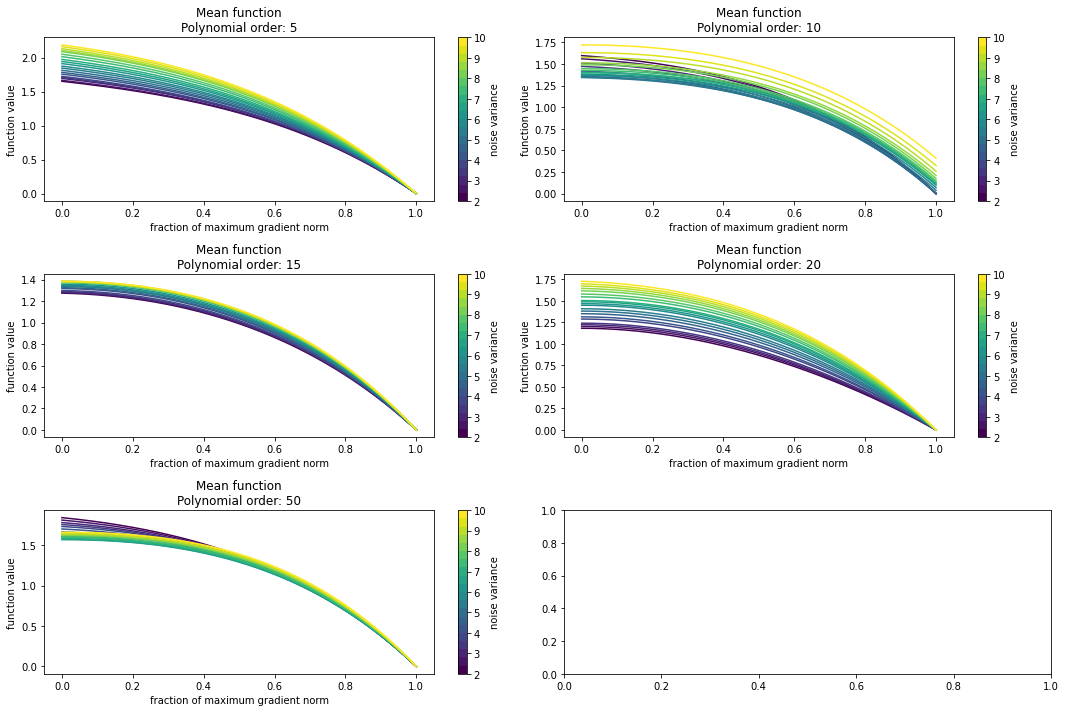

In [72]:
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))

fig,axs = plt.subplots(ncols = 2,nrows = 3,figsize=(15,10))

for col in range(len(R)):
        
    if len(R[col]) == 0:
        continue

    viridis = cm.get_cmap('viridis', 256)
    colors = viridis(np.linspace(0, 1, len(R[col])))
    newcmp = ListedColormap(colors)

    for i in range(len(R[col])):

        #m,s = R[col][i].T

        #axs[col].errorbar(np.arange(len(m))/ncl[col],m,s,color=colors[i])
        axs[col//2,col%2].plot(xR[col][i],R[col][i],color=colors[i])

    axs[col//2,col%2].set_title(f"Mean function\nPolynomial order: {ncl[col]}")
    axs[col//2,col%2].set_xlabel("fraction of maximum gradient norm")
    axs[col//2,col%2].set_ylabel("function value")
    plt.colorbar(cm.ScalarMappable(norm=norm, cmap=newcmp),ax=axs[col//2,col%2],label='noise variance')

plt.tight_layout()        
plt.show()

# umap

In [77]:
w = np.linspace(2,10,10)
num_classes = 5
C,L,Q = [],[],[]

model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

for i,m in enumerate(w):


    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=10)

    cte,linear,quad = [],[],[]
    for it in range(100):

        ims = next(gen_batch_train.as_numpy_iterator())
        cte.append(np.squeeze(get_cte(ims[0])))
        linear.append(np.squeeze(get_linear(ims[0])))
        quad.append(np.squeeze(get_quad(ims[0])))

    cte = np.concatenate(cte,axis=0)
    linear = np.concatenate(linear,axis=0)
    quad = np.concatenate(quad,axis=0)

    C.append(np.copy(cte))
    L.append(np.copy(linear))
    Q.append(np.copy(quad))

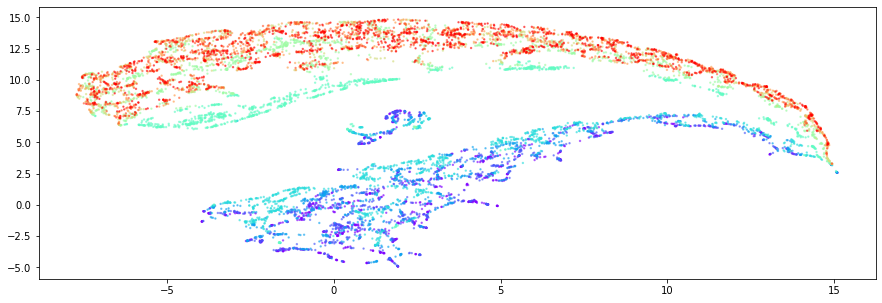

In [117]:
X = np.concatenate([np.expand_dims(C,axis=-1),np.expand_dims(L,axis=-1),Q],axis=-1)
reducer = umap.UMAP()

m = np.expand_dims(np.expand_dims(np.mean(X,axis=(1,2)),axis=-1),axis=-1)
s = np.expand_dims(np.expand_dims(np.std(X,axis=(1,2)),axis=-1),axis=-1)
X1 = (X-m)/s
X1 = np.concatenate(X1,axis=0)
c = np.concatenate([i*np.ones(len(X[0])) for i in range(len(X))])


colors = cm.rainbow(np.linspace(0,1,len(X)))
c = colors[np.asarray(c,dtype='int')]
plt.figure(figsize=(15,5))

embedding = reducer.fit_transform(X1)
plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)

plt.show()

In [118]:
w = np.linspace(2,10,10)
num_classes = 20
C,L,Q = [],[],[]

model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

for i,m in enumerate(w):


    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=10)

    cte,linear,quad = [],[],[]
    for it in range(100):

        ims = next(gen_batch_train.as_numpy_iterator())
        cte.append(np.squeeze(get_cte(ims[0])))
        linear.append(np.squeeze(get_linear(ims[0])))
        quad.append(np.squeeze(get_quad(ims[0])))

    cte = np.concatenate(cte,axis=0)
    linear = np.concatenate(linear,axis=0)
    quad = np.concatenate(quad,axis=0)

    C.append(np.copy(cte))
    L.append(np.copy(linear))
    Q.append(np.copy(quad))

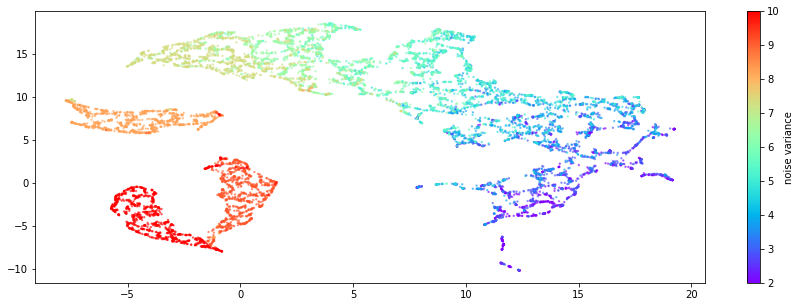

In [121]:
X = np.concatenate([np.expand_dims(C,axis=-1),np.expand_dims(L,axis=-1),Q],axis=-1)
reducer = umap.UMAP()

m = np.expand_dims(np.expand_dims(np.mean(X,axis=(1,2)),axis=-1),axis=-1)
s = np.expand_dims(np.expand_dims(np.std(X,axis=(1,2)),axis=-1),axis=-1)
X1 = (X-m)/s
X1 = np.concatenate(X1,axis=0)
c = np.concatenate([i*np.ones(len(X[0])) for i in range(len(X))])


colors = cm.rainbow(np.linspace(0,1,len(X)))
c = colors[np.asarray(c,dtype='int')]
plt.figure(figsize=(15,5))

embedding = reducer.fit_transform(X1)
plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.rainbow),label='noise variance')

plt.show()

# PCA

In [ ]:
w = np.linspace(2,10,10)
num_classes = 5
C,L,Q = [],[],[]

model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

for i,m in enumerate(w):


    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=10)

    cte,linear,quad = [],[],[]
    for it in range(100):

        ims = next(gen_batch_train.as_numpy_iterator())
        cte.append(np.squeeze(get_cte(ims[0])))
        linear.append(np.squeeze(get_linear(ims[0])))
        quad.append(np.squeeze(get_quad(ims[0])))

    cte = np.concatenate(cte,axis=0)
    linear = np.concatenate(linear,axis=0)
    quad = np.concatenate(quad,axis=0)

    C.append(np.copy(cte))
    L.append(np.copy(linear))
    Q.append(np.copy(quad))

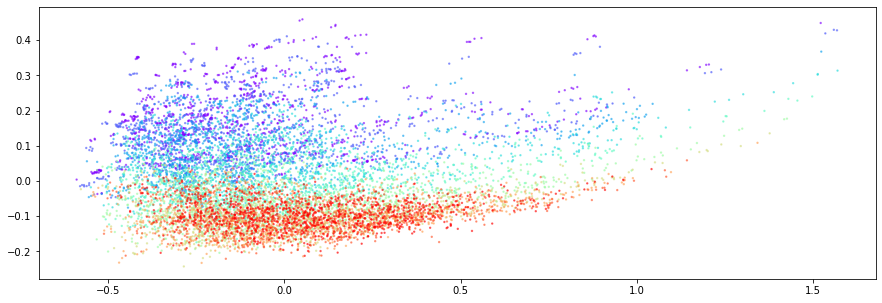

In [5]:
X = np.concatenate([np.expand_dims(C,axis=-1),np.expand_dims(L,axis=-1),Q],axis=-1)
pca = PCA(n_components = 2)

m = np.expand_dims(np.expand_dims(np.mean(X,axis=(1,2)),axis=-1),axis=-1)
s = np.expand_dims(np.expand_dims(np.std(X,axis=(1,2)),axis=-1),axis=-1)
X1 = (X-m)/s
X1 = np.concatenate(X1,axis=0)
c = np.concatenate([i*np.ones(len(X[0])) for i in range(len(X))])
pca.fit(X1)


colors = cm.rainbow(np.linspace(0,1,len(X)))
c = colors[np.asarray(c,dtype='int')]
plt.figure(figsize=(15,5))

embedding = pca.transform(X1)
plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)

plt.show()

In [6]:
w = np.linspace(2,10,10)
num_classes = 20
C,L,Q = [],[],[]

model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = num_classes)
model.load_weights(f"./checkpoints/dectaylor_{typ}_{num_classes}")
get_cte = tf.keras.models.Model(model.input,model.get_layer('cte').output)
get_linear = tf.keras.models.Model(model.input,model.get_layer('linear').output)
get_quad = tf.keras.models.Model(model.input,model.get_layer('quad').output)

for i,m in enumerate(w):


    gen_batch_train,gen_batch_val = get_generators(typ,var1_d=0,var1_u=w[i],CROP1=CROP,BATCH_SIZE=10)

    cte,linear,quad = [],[],[]
    for it in range(100):

        ims = next(gen_batch_train.as_numpy_iterator())
        cte.append(np.squeeze(get_cte(ims[0])))
        linear.append(np.squeeze(get_linear(ims[0])))
        quad.append(np.squeeze(get_quad(ims[0])))

    cte = np.concatenate(cte,axis=0)
    linear = np.concatenate(linear,axis=0)
    quad = np.concatenate(quad,axis=0)

    C.append(np.copy(cte))
    L.append(np.copy(linear))
    Q.append(np.copy(quad))

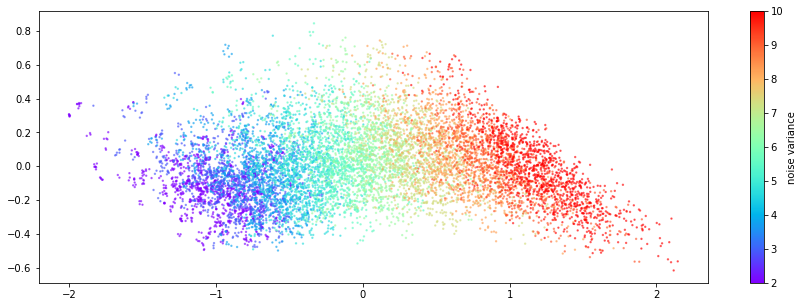

In [8]:
X = np.concatenate([np.expand_dims(C,axis=-1),np.expand_dims(L,axis=-1),Q],axis=-1)
pca = PCA(n_components = 2)

m = np.expand_dims(np.expand_dims(np.mean(X,axis=(1,2)),axis=-1),axis=-1)
s = np.expand_dims(np.expand_dims(np.std(X,axis=(1,2)),axis=-1),axis=-1)
X1 = (X-m)/s
X1 = np.concatenate(X1,axis=0)
c = np.concatenate([i*np.ones(len(X[0])) for i in range(len(X))])
pca.fit(X1)


colors = cm.rainbow(np.linspace(0,1,len(X)))
c = colors[np.asarray(c,dtype='int')]
plt.figure(figsize=(15,5))

embedding = pca.transform(X1)
plt.scatter(embedding[:, 0],embedding[:, 1],s=2,color=c,alpha=0.5)
norm = mpl.colors.Normalize(vmin=np.amin(w), vmax=np.amax(w))
plt.colorbar(cm.ScalarMappable(norm=norm, cmap=cm.rainbow),label='noise variance')

plt.show()

# Plot the model

In [18]:
model = get_model("decreasing_taylor",it_lim=1,image_size=image_size,num_classes = 5)

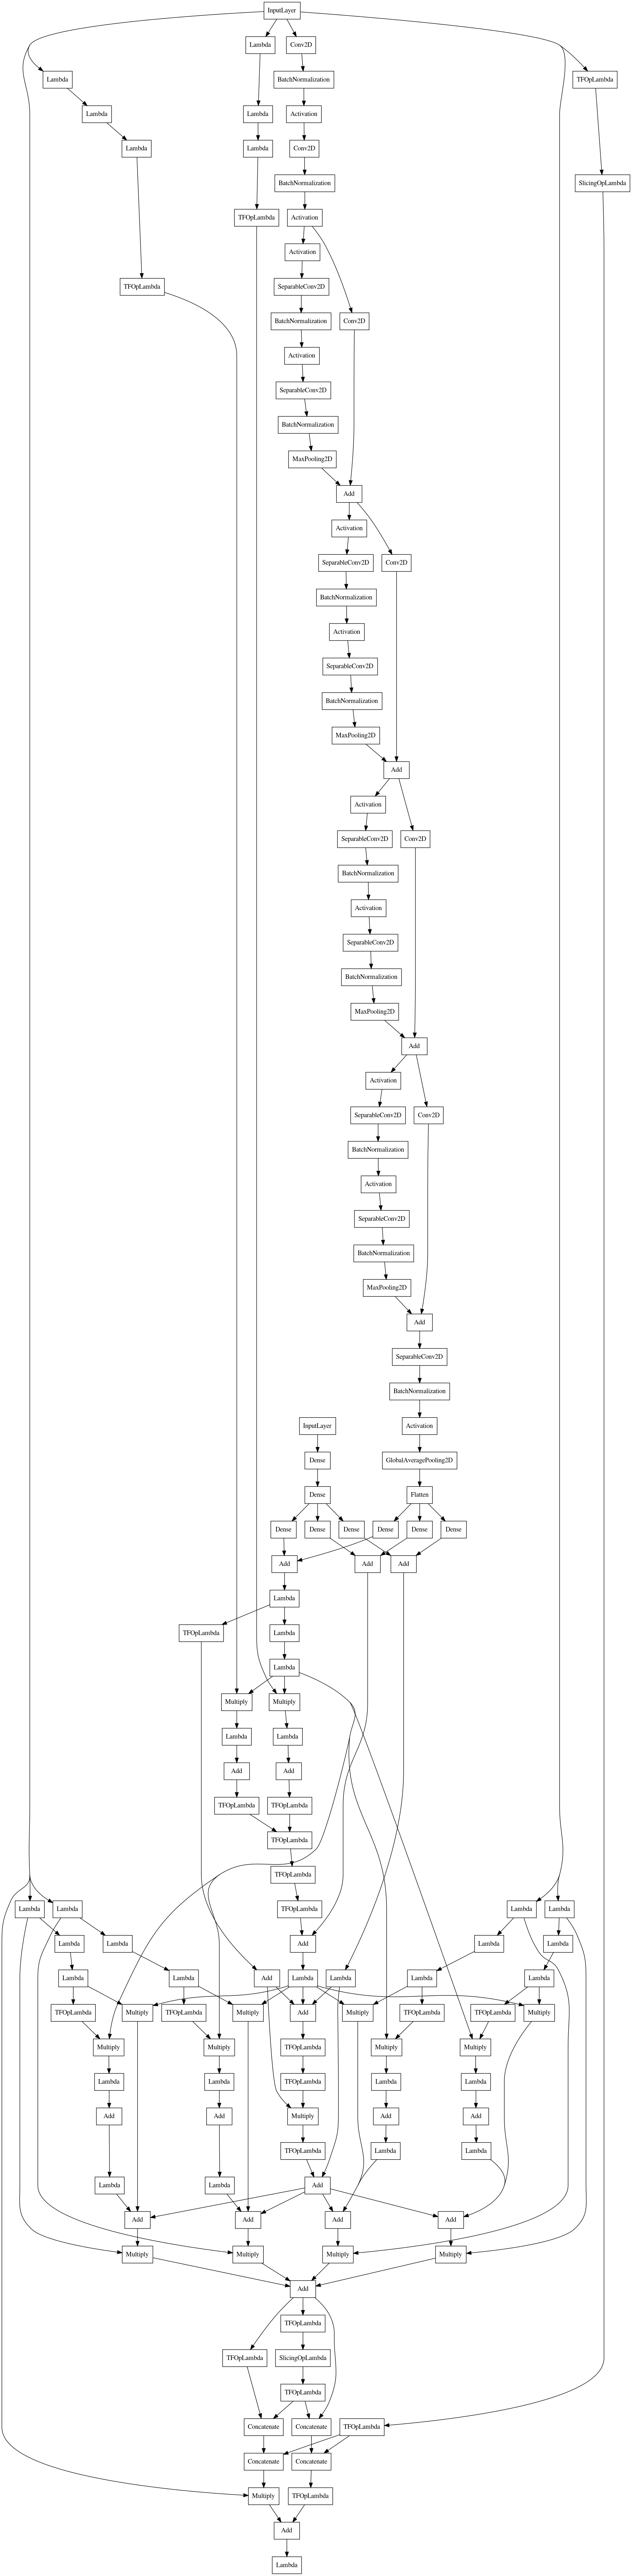

In [19]:
tf.keras.utils.plot_model(model,
    to_file="taylor.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=False,)